In [ ]:
# !pip install kwant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import scipy.sparse as sp
from scipy.constants import hbar, e, m_e, h
from types import SimpleNamespace
import tinyarray
import time
import sys
import os

In [2]:
# define pauli matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, 1]])#tinyarray.array([[1, 0], [0, -1]])

lat = kwant.lattice.honeycomb(a = 1.0, norbs=2)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def onstie(site, param):
    x, y = site.pos
    if np.random.rand() < param.p:
        return param.U_imp+ param.m*sigma_0 if site.family == a_lat else -param.m*sigma_0
    else:
        return param.m*sigma_0 if site.family == a_lat else -param.m*sigma_0
def nn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return -np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))*sigma_0
def nnn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))*sigma_z*param.s


def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:

        if ans < 0: return 2*np.pi + ans
        else: return ans

    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans

    else: raise TypeError("atan is getting neither floats nor arrays")

# define graphene lattices
def create_graphene_hexagonal_system(r, start = 0, a = 1.0, norb = 2, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 6, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            else: y += 1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    
    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onstie # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site

    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1: del sys[s]

    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping

    return sys

def create_graphene_tiangular_system(r, start = 0, a = 1.0, norb = 2, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 3, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside

    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onstie # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site
    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    
    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping
    
    return sys

def create_graphene_circular_system(r, a=1.0, norb=2):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    
    sys = kwant.Builder()
    sys[lat.shape(lambda pos: np.linalg.norm(np.array([*pos])) < r, (0, 0))] = onstie
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping

    return sys

def create_graphene_nanoribbon(width, length, a=1.0, norb=1):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    sys = kwant.Builder()
    sys[lat.shape(lambda pos: abs(pos[1]) < width and abs(pos[0])<length, (0, 0))] = onstie
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    sys[lat_neighbors_2] = nnn_hopping
    # sys[lat.neighbors(n=2)] = nnn_hopping
    # attach leads
    sym = kwant.TranslationalSymmetry((-a, 0))
    lead = kwant.Builder(sym)
    lead[lat.shape(lambda pos: abs(pos[1]) < width, (0, 0))] = onstie
    lead[lat.neighbors(n=1)] = nn_hopping
    # lead[lat.neighbors(n=2)] = nnn_hopping
    lead[lat_neighbors_2] = nnn_hopping
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    return sys

In [3]:
class Hamiltonian:
    def __init__(self, h, norb=1, N=None):
        self.h = h
        if N is None: self.N = h.shape[0]
        else: self.N = N
        self.n_sites = h.shape[0]//norb
        self.sol = None
        self.energies = None
        self.eigenstates = None
        self.norb=norb
    
    def solve(self, k=None, return_eigenvectors=True):
        
        if k is None: k = self.N-2*self.norb
        self.k = k
        self._returned_eigenvectors = return_eigenvectors
        if return_eigenvectors is False:
            self.sol =  [sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)]
        else:
            self.sol =  sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)
    
    def get_eigenvalues(self):
        if self.sol is None: self.solve(return_eigenvectors=False)
        self.eigenenergies_preorb = np.sort(self.sol[0])
        if self.norb > 1:
            self.eigenenergies = np.zeros((self.k//self.norb, self.norb))
            for orb in range(self.norb):
                self.eigenenergies[:, orb] = self.eigenenergies_preorb[orb::self.norb]
        else: self.eigenenergies = self.eigenenergies_preorb
        return self.eigenenergies
    
    def get_eigenstates(self):
        if self._returned_eigenvectors is False: self.solve(return_eigenvectors=True)
        self.eigenstates_preorb = (self.sol[1].T)[np.argsort(self.sol[0])]
        if self.norb > 1:    
            # self.eigenstates = np.zeros((self.k, self.n_sites, self.norb), dtype=complex)
            self.eigenstates = np.zeros((self.k//self.norb, self.n_sites, self.norb), dtype=complex)
            for orb in range(self.norb):
                self.eigenstates[:, :, orb] = self.eigenstates_preorb[::self.norb, orb::self.norb]
        else:
            self.eigenstates = self.eigenstates_preorb
        return self.eigenstates
    
    def get_eigenstate(self, i, orb=None):
        if self.eigenstates is None: self.get_eigenstates()
        if orb is None: return self.eigenstates[i]
        elif orb > self.norb: raise ValueError("orbital index out of range")
        return self.eigenstates[i, :, orb-1]
    
    def zero_energy(self):
        if self.eigenenergies is None: self.get_eigenvalues()
        return np.where(np.allclose(np.abs(self.eigenenergies), 0, rtol=1e-2))[0]
    
    def plot_state(self, system, i):
        if self.eigenstates is None: self.get_eigenstates()
        kwant.plotter.map(sys=system, value=self.eigenstates[i], oversampling=10, cmap='inferno', show=True, dpi=400)
        plt.show()


In [4]:
# calculate the current
def calculate_current(sys, state, param, plot=False, polarized = False, up = None):
    if polarized is True:
        currentz = kwant.operator.Current(sys, sigma_z)
        current0 = kwant.operator.Current(sys, sigma_0)
        if up is None:
            i = currentz(state, params=dict(param = param))
        elif up is True:
            i = (current0(state, params=dict(param = param)) + currentz(state, params=dict(param = param)))/2
        else:
            i = (current0(state, params=dict(param = param)) - currentz(state, params=dict(param = param)))/2
    else: 
        current = kwant.operator.Current(sys, sigma_0)
        i = current(state, params=dict(param=param))
    if plot:
        kwant.plotter.current(sys, i)
        plt.show()
    return i

def calculate_current_2(sys, state_number, param, plot=False, polarized = False, up = None):
    # h = sys.hamiltonian_submatrix(params=dict(param = SimpleNamespace(B=0.0, t_prime=0.05, m=0.0)), sparse=True)
    h = sys.hamiltonian_submatrix(params=dict(param = param), sparse=True)
    N = h.shape[0]
    hamiltonian = Hamiltonian(h, norb=2)
    hamiltonian.solve(return_eigenvectors=True)
    energies = hamiltonian.get_eigenvalues()

    state1 = hamiltonian.get_eigenstate(state_number, orb=1)
    state2 = hamiltonian.get_eigenstate(state_number, orb=2)

    state = np.zeros(N)*0.0j
    state[0::2] = state1
    state[1::2] = state2
    
    if polarized is True:
        currentz = kwant.operator.Current(sys, sigma_z)
        current0 = kwant.operator.Current(sys, sigma_0)
        if up is None:
            i = currentz(state, params=dict(param = param))
        elif up is True:
            i = (current0(state, params=dict(param = param)) + currentz(state, params=dict(param = param)))/2
        else:
            i = (current0(state, params=dict(param = param)) - currentz(state, params=dict(param = param)))/2
    else: 
        current = kwant.operator.Current(sys, sigma_0)
        i = current(state, params=dict(param=param))
    if plot:
        kwant.plotter.current(sys, i)
        plt.show()
    return i

In [5]:
def scatter(arr, sort=True, show=False):
    if sort:
        plt.scatter(range(len(arr)), np.sort(arr))
    else:
        plt.scatter(range(len(arr)), arr)
    plt.grid(True)
    plt.show()

In [6]:
def total_spin_current(sys, parameters,Nedge=15, sym_point = None):
    # I will assume that the system is symmetric around some point
    graph = list(sys.graph)
    if sym_point is None:
        sym_point = np.array([0., 0.])
        for s in sys.sites:
            sym_point += s.pos
        sym_point/=len(sym_point)
    h = sys.hamiltonian_submatrix(params=dict(param=parameters), sparse=True)
    eig_energies, _eig_vecs = sla.eigsh(h, k=2*Nedge, sigma=1e-9)
    eig_vecs = _eig_vecs.T

    def cut(site_to, site_from):
        x0, y0 = sym_point
        xi, yi = site_from.pos
        xf, yf = site_to.pos
        return xf <= x0 and xi > x0 and yi < 0 and yf < 0
    current = kwant.operator.Current(sys, sigma_z, where=cut, sum=True)
    tot_cur = current(eig_vecs[0], eig_vecs[0], params=dict(param=parameters))
    return tot_cur

In [7]:
triangular_dot = create_graphene_tiangular_system(10, np.pi/2, 1.0, 2, 'zigzag')
hexa_dot = create_graphene_hexagonal_system(10, np.pi/3, 1.0, 2, 'zigzag')
circ_dot = create_graphene_circular_system(10)

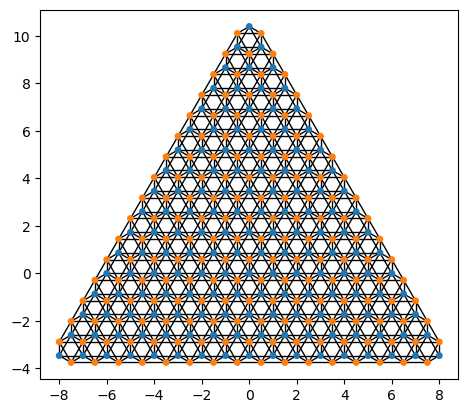

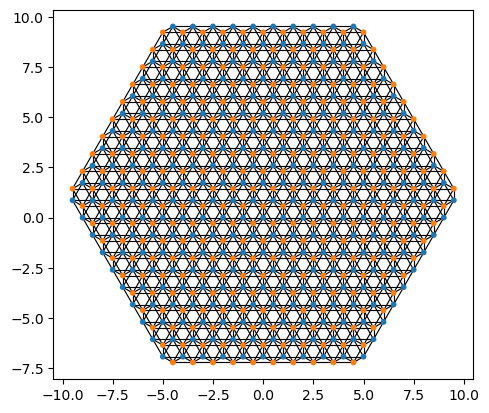

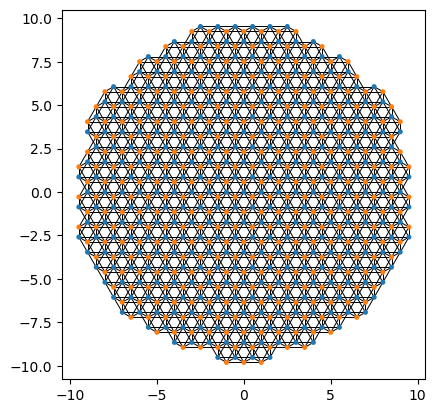

In [8]:
kwant.plot(triangular_dot)
kwant.plot(hexa_dot)
kwant.plot(circ_dot)
plt.show()

In [18]:
where = lambda s: np.linalg.norm(s.pos) < 4
my_parameters = SimpleNamespace(B=0.0, m=0.0, t_prime=0.01, t2=0.0, U_imp=0.0, p=0.0, s=+1)
triangular_dot_f = triangular_dot.finalized()
hexa_dot_f = hexa_dot.finalized()
circ_dot_f = circ_dot.finalized()

In [19]:
# component 'xx'
s_factory = kwant.kpm.LocalVectors(triangular_dot_f, where)
cond_xx = kwant.kpm.conductivity(triangular_dot_f, alpha='x', beta='x', mean=True,
                                 num_vectors=None, vector_factory=s_factory, params=dict(param=my_parameters))
# component 'xy'
s_factory = kwant.kpm.LocalVectors(triangular_dot_f, where)
cond_xy = kwant.kpm.conductivity(triangular_dot_f, alpha='x', beta='y', mean=True,
                                 num_vectors=None, vector_factory=s_factory, params=dict(param=my_parameters))

energies = cond_xx.energies
cond_array_xx = np.array([cond_xx(e, temperature=0.0) for e in energies])
cond_array_xy = np.array([cond_xy(e, temperature=0.0) for e in energies])

# area of the unit cell per site
area_per_site = np.abs(np.cross(*lat.prim_vecs)) / len(lat.sublattices)
cond_array_xx /= area_per_site
cond_array_xy /= area_per_site

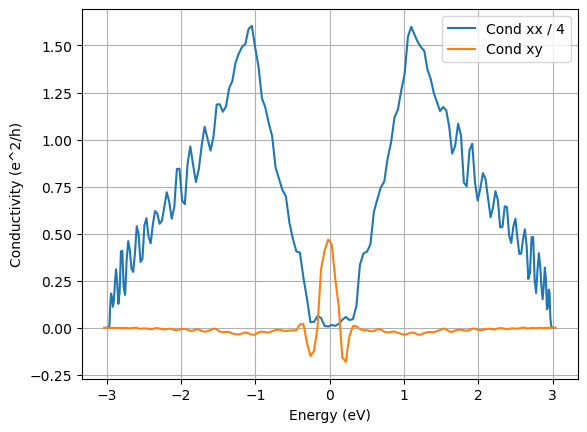

In [20]:
plt.plot(energies, cond_array_xx/4, label='Cond xx / 4')
plt.plot(energies, cond_array_xy, label='Cond xy')
plt.xlabel('Energy (eV)')
plt.ylabel('Conductivity (e^2/h)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# component 'xx'
s_factory = kwant.kpm.LocalVectors(hexa_dot_f, where)
cond_xx = kwant.kpm.conductivity(hexa_dot_f, alpha='x', beta='x', mean=True,
                                 num_vectors=None, vector_factory=s_factory, params=dict(param=my_parameters))
# component 'xy'
s_factory = kwant.kpm.LocalVectors(hexa_dot_f, where)
cond_xy = kwant.kpm.conductivity(hexa_dot_f, alpha='x', beta='y', mean=True,
                                 num_vectors=None, vector_factory=s_factory, params=dict(param=my_parameters))

energies = cond_xx.energies
cond_array_xx = np.array([cond_xx(e, temperature=0.0) for e in energies])
cond_array_xy = np.array([cond_xy(e, temperature=0.0) for e in energies])

# area of the unit cell per site
area_per_site = np.abs(np.cross(*lat.prim_vecs)) / len(lat.sublattices)
cond_array_xx /= area_per_site
cond_array_xy /= area_per_site

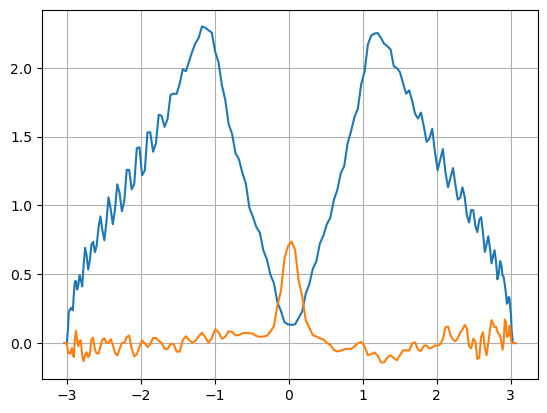

In [12]:
plt.plot(energies, cond_array_xx/4)
plt.plot(energies, cond_array_xy)
plt.grid(True)
plt.show()

In [13]:
# component 'xx'
s_factory = kwant.kpm.LocalVectors(circ_dot_f, where)
cond_xx = kwant.kpm.conductivity(circ_dot_f, alpha='x', beta='x', mean=True,
                                 num_vectors=None, vector_factory=s_factory, params=dict(param=my_parameters))
# component 'xy'
s_factory = kwant.kpm.LocalVectors(circ_dot_f, where)
cond_xy = kwant.kpm.conductivity(circ_dot_f, alpha='x', beta='y', mean=True,
                                 num_vectors=None, vector_factory=s_factory, params=dict(param=my_parameters))

energies = cond_xx.energies
cond_array_xx = np.array([cond_xx(e, temperature=0.0) for e in energies])
cond_array_xy = np.array([cond_xy(e, temperature=0.0) for e in energies])

# area of the unit cell per site
area_per_site = np.abs(np.cross(*lat.prim_vecs)) / len(lat.sublattices)
cond_array_xx /= area_per_site
cond_array_xy /= area_per_site

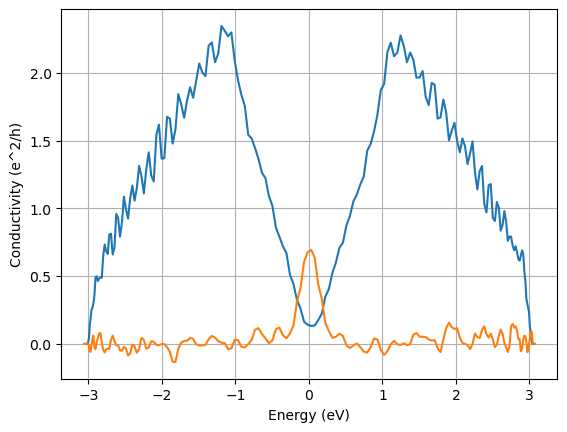

In [14]:
plt.plot(energies, cond_array_xx/4)
plt.plot(energies, cond_array_xy)
plt.xlabel('Energy (eV)')
plt.ylabel('Conductivity (e^2/h)')
plt.grid(True)
plt.show()

In [10]:
h_circ = circ_dot_f.hamiltonian_submatrix(params=dict(param=my_parameters))
h_tri = triangular_dot_f.hamiltonian_submatrix(params=dict(param=my_parameters))
h_hexa = hexa_dot_f.hamiltonian_submatrix(params=dict(param=my_parameters))

In [11]:
eigen_energies, eigen_states = np.linalg.eigh(h_tri)
eigen_energies_h, eigen_states_h = np.linalg.eigh(h_hexa)
# eigen_energies, eigen_states = np.linalg.eigh(h_tri)

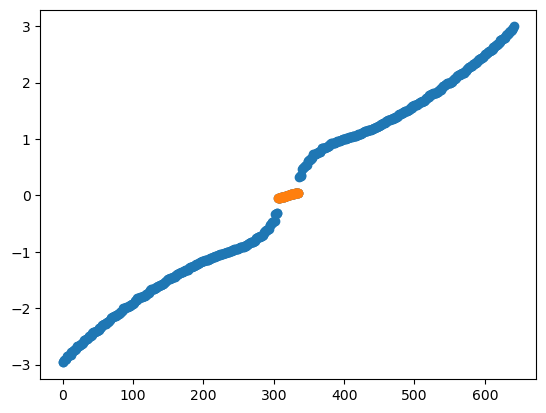

In [13]:
s, f = 306, 336
plt.scatter(range(len(eigen_energies)), eigen_energies)
plt.scatter(range(s, f), eigen_energies[s:f])
plt.show()

-0.007805527514152536


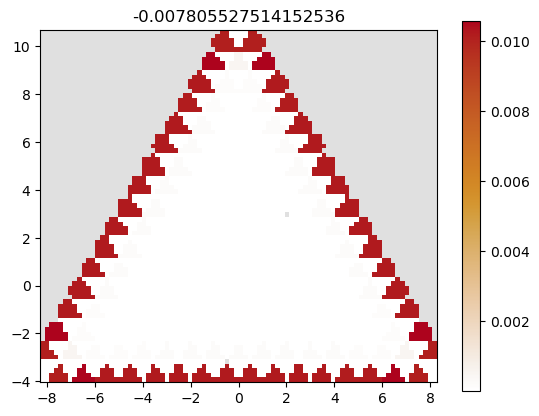

In [14]:
ind = 319
syst = triangular_dot_f
print(eigen_energies[ind])
kwant.plotter.map(syst, np.abs(eigen_states[0::2, ind])**2, show=False)
plt.title(eigen_energies[ind])

plt.show()

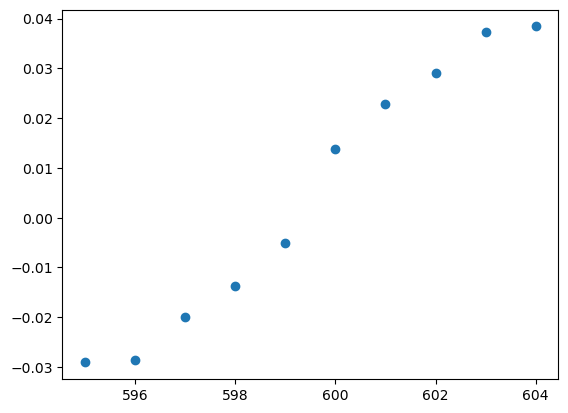

In [15]:
s, f = 595, 605
# plt.scatter(range(len(eigen_energies_h)), eigen_energies_h)
plt.scatter(range(s, f), eigen_energies_h[s:f])
plt.show()

0.013815126823443848


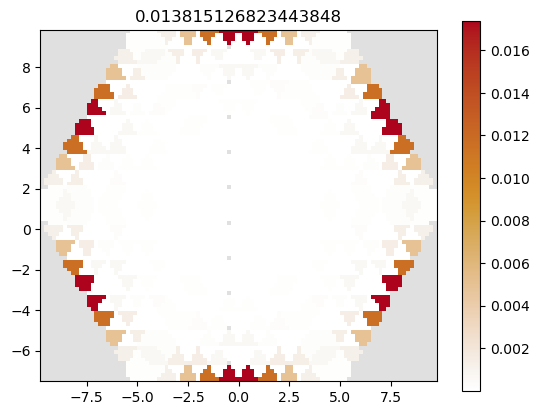

In [12]:
ind = 600
syst = hexa_dot_f
print(eigen_energies_h[ind])
kwant.plotter.map(syst, np.abs(eigen_states_h[0::2, ind])**2, show=False)
plt.title(eigen_energies_h[ind])

plt.show()

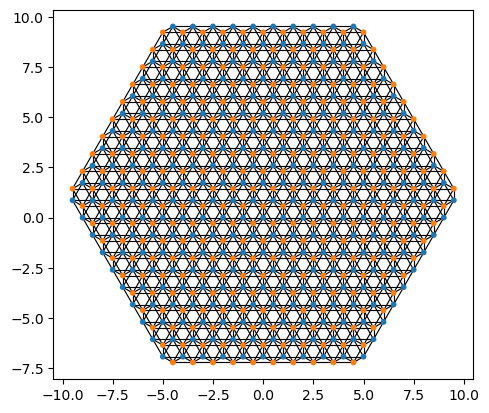

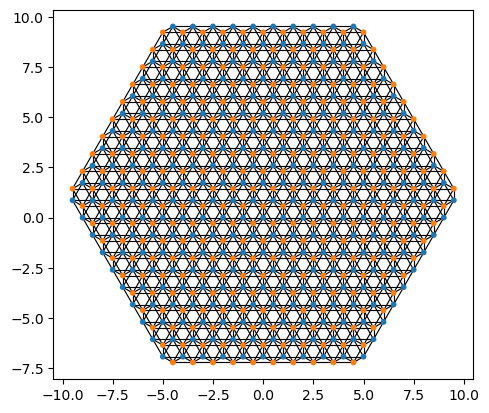

In [13]:
kwant.plot(hexa_dot)

In [14]:
hexa_dot_wl = hexa_dot.__copy__()

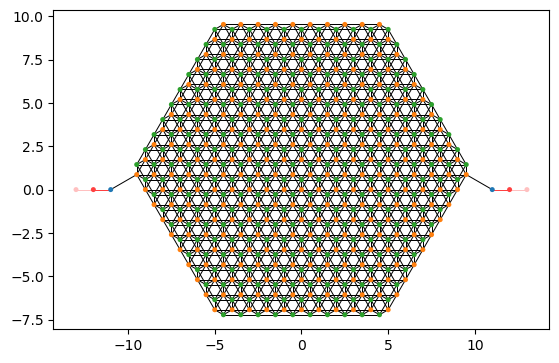

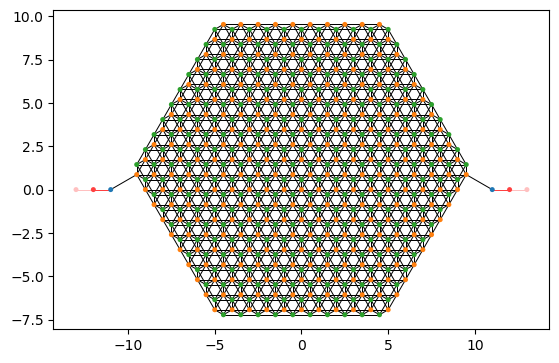

In [15]:
sq_lattice = kwant.lattice.square(a=1.0, norbs=2)

added_site = sq_lattice(-11, 0)

added_site2 = sq_lattice(11, 0)

hexa_dot_wl.leads = []

_lead1 = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
_lead1[added_site] = 0*sigma_0
_lead1[sq_lattice.neighbors(1)] = -1*sigma_0

hexa_dot_wl[added_site] = 0*sigma_0
hexa_dot_wl[added_site, a_lat(-10, 1)] = -1*sigma_0
hexa_dot_wl.attach_lead(_lead1)

_lead2 = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
_lead2[added_site2] = 0*sigma_0
_lead2[sq_lattice.neighbors(1)] = -1*sigma_0

hexa_dot_wl[added_site2] = 0*sigma_0
hexa_dot_wl[added_site2, a_lat(9, 1)] = -1*sigma_0
hexa_dot_wl.attach_lead(_lead2)

kwant.plot(hexa_dot_wl)

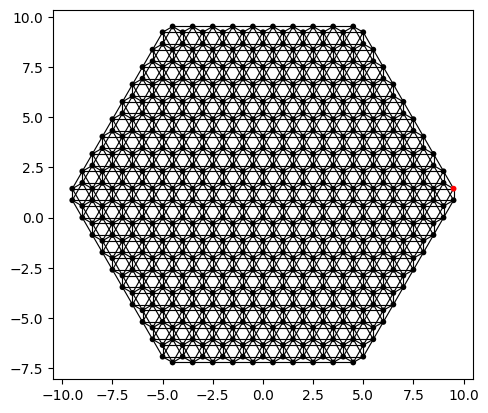

In [ ]:
def site_color(site):
    if site.tag == (9, 1) and site.family==b_lat:
        return "r"
    else:        return "k"

kwant.plot(hexa_dot_wl, site_color=site_color)
plt.show()

/tmp/ipykernel_176996/3972957743.py:6: RuntimeWarning:

The plotted data contains 1.86% of values overflowing upper limit 0.208057 



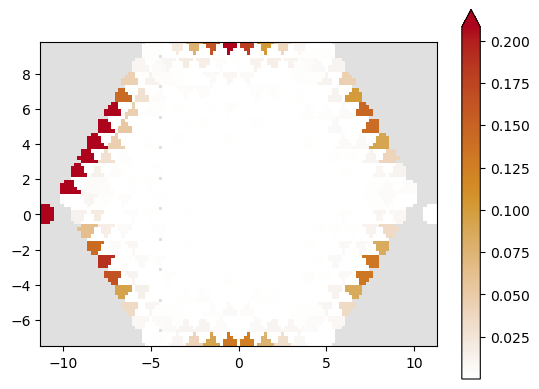

In [22]:
parameters_td = SimpleNamespace(B = 0., m=0.0, t_prime=1e-2, t2=0.0, p=0.0, U_imp=0., s=1)

psi = kwant.wave_function(sys=hexa_dot_wl.finalized(), energy=0.0, params=dict(param=parameters_td))
up = lambda n: psi(n)[:, 0::2]
down = lambda n: psi(n)[:, 1::2]
kwant.plotter.map(hexa_dot_wl.finalized(), np.abs(up(0)[1])**2)
plt.show()

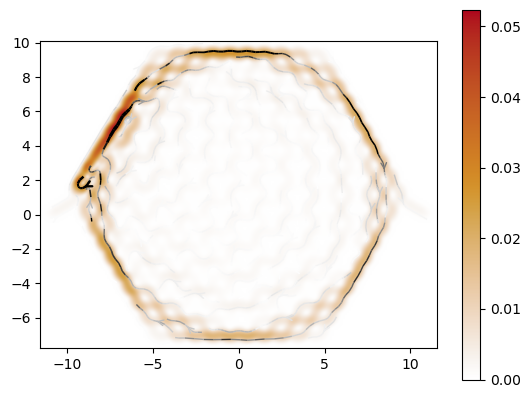

In [23]:
current_z = kwant.operator.Current(hexa_dot_wl.finalized(), sigma_z)
spin_current_arr = current_z(psi(0)[0], params=dict(param=parameters_td))
kwant.plotter.current(hexa_dot_wl.finalized(), spin_current_arr)
plt.show()